# Crank-Nicholson Algorithm for Time-Dependent Schrodinger Equation

The time dependent Schrodinger equation in one dimension is

$$
    \frac{\partial\psi(x,t)}{\partial t} = \frac{i\hbar}{2m}\frac{\partial^2\psi(x,t)}{\partial x^2}-\frac{i V(x)}{\hbar}\psi(x,t)
$$

With boundary conditions

$$
    \psi(a,t) = \psi(b,t) = 0~\mathrm{and}~\psi(x,0) = g(x)
$$

The numerical solution  solves for values of the wavefunction on a regular grid, where

$$
    \psi_j^{(k)} = \psi(a+j\Delta x, k\tau)
$$

The derivatives are replaced by finite differences, resulting in

$$
    \frac{i\hbar}{2m \Delta x^2}\left(\psi_{j+1}^{(k)}+\psi_{j-1}^{(k)}-2\psi_j^{(k)} - iV(a+j\Delta x)/\hbar \psi_j^{(k)}\right) = \sum_{m=0}^N i H_{j,m}\psi_m^{(k)}.
$$

The L.H.S. can be replaced by forward or backward difference

$$
    \mathrm{forward}~\frac{\psi_j^{(k+1)}-\psi_j^{(k)}}{\tau}~\mathrm{and}~\mathrm{backward}~\frac{\psi_j^{(k)}-\psi_j^{(k-1)}}{\tau}.
$$

Crank-Nicholson averages forward and backward, resulting in

$$
(1-iH\tau/2)\psi^{(k+1)}=\left(1+iH\tau/2\right)\psi^{(k)}.
$$

Crank-Nicholson is second order in $t$, and second order in $\Delta x$, and gives unitary evolution in time. However it assumes a time-independent Hamiltonian.

# Transition Times in the Landau-Zener model

From the paper of [N.V. Vitanov](http://cds.cern.ch/record/372213/files/9811066.pdf) we have

$$
    i\frac{d}{dt}\begin{pmatrix}
        c_1(t)\\
        c_2(t)
    \end{pmatrix}
    =
    \frac{1}{2}\begin{pmatrix}
        -\Delta(t) & \Omega(t) \\
        \Omega(t) & \Delta(t)
    \end{pmatrix}\begin{pmatrix}
        c_1(t)\\
        c_2(t)
    \end{pmatrix},
$$

where $c_{i}(t)$ are the probability amplitudes of states $\psi_{i}$, $\Omega(t)$ is the coupling between the two states and $\Delta(t)$ is half the difference between the system transition frequency and the field ferquency.

In Landua-Zener, $\Omega(t) = \mathrm{constant}$ and $\Delta(t)=\beta^2 t$, with $t$ running from $-\infty\rightarrow \infty$.

In [ ]:
def differentialEquation(t, c):
    c1 = (-Delta(t)*c[0]+Omega(t)*c[1])/1j
    c2 = (Omega(t)*c[0]+Delta(t)*c[1])/1j
    return [c1, c2]

In [2]:
import numpy as np

beta = 3
Omega = lambda t: 1
Delta = lambda t: beta**2*t

t = np.linspace(-15,5,40001)
from scipy.integrate import solve_ivp
sol = solve_ivp(differentialEquation, [t.min(), t.max()], [1+0j,0+0j], t_eval=t)

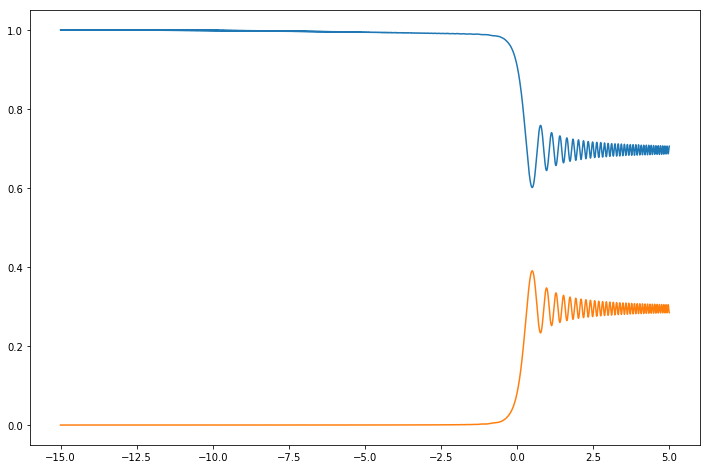

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(sol.t, np.abs(sol.y[0])**2)
ax.plot(sol.t, np.abs(sol.y[1])**2)

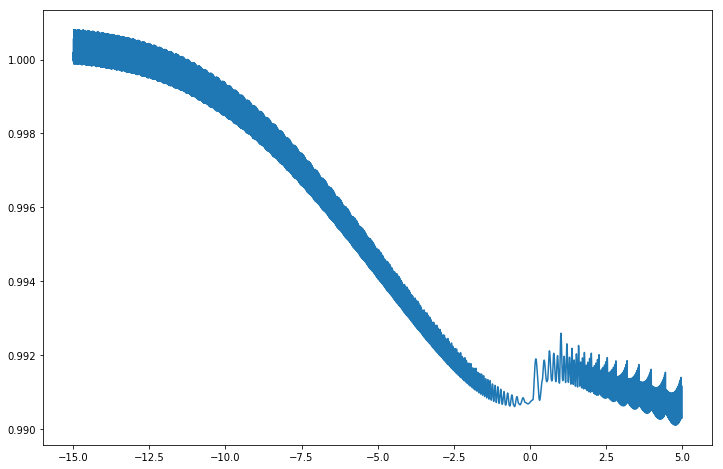

In [4]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(sol.t, (np.abs(sol.y[0])**2+np.abs(sol.y[1])**2))

The sum of the probabilities should be 1 for all timescales, but due to numeric integration it varies over time.

In [5]:
def Ham(t):
    return np.array([[-Delta(t), Omega(t)],[Omega(t), Delta(t)]])

In [6]:
def propagate(H1,H2,phi1,phi2,dt):
    a = 4/(1j*H1*dt+2)
    b = 4/(1j*H2*dt-2)
    return (a+b)@phi1+phi2

In [7]:
t = np.linspace(-15,5,500000)

phi = np.zeros([len(t),2], dtype = complex)
phi[0,0] = 1
phi[1,0] = 1

Hamiltonians = [None]*t.size
for idt, ti in enumerate(t):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

for idH, H in enumerate(Hamiltonians[2:]):
    phi[idH+2] = propagate(Hamiltonians[idH+1],Hamiltonians[idH],phi[idH+1],phi[idH],dt=np.diff(t)[0])

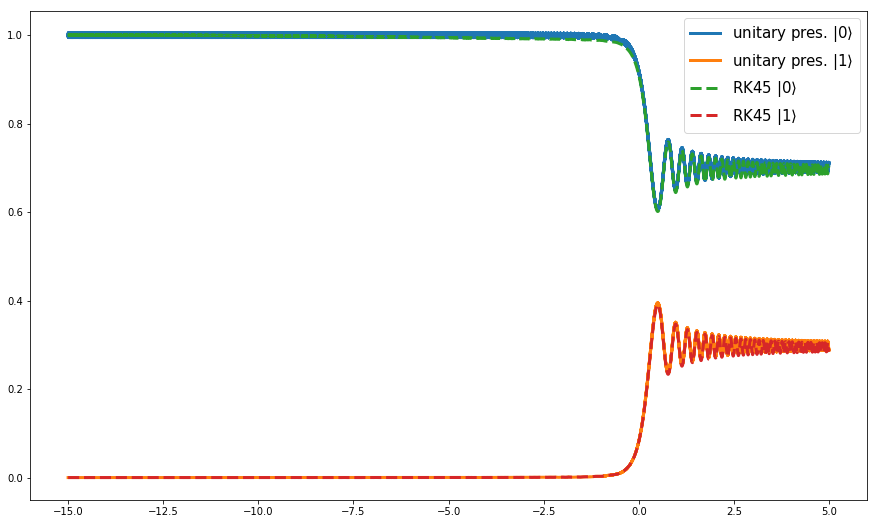

In [8]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phi[:,0])**2, 'C0', label = r'unitary pres. $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phi[:,1])**2, 'C1', label = r'unitary pres. $\left|1\right\rangle$', lw = 3)
ax.plot(sol.t, np.abs(sol.y[0])**2, '--C2', label = r'RK45 $\left|0\right\rangle$', lw = 3)
ax.plot(sol.t, np.abs(sol.y[1])**2, '--C3', label = r'RK45 $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15);

The unitarity preserving method has oscillations occuring at $t<0$, which are further dampened when using the non-unitarity preserving RK45 method. The unitarity preserving method is essentially two O(2) integration schemes averaged, so it might be worthwhile to find a higher order unitarity preserving integration scheme.

In general both schemes seem to agree with each otehr, especially at $t>0$, which is what we are interested in, since we want to know the probabilities of being in each state at $t_f$.

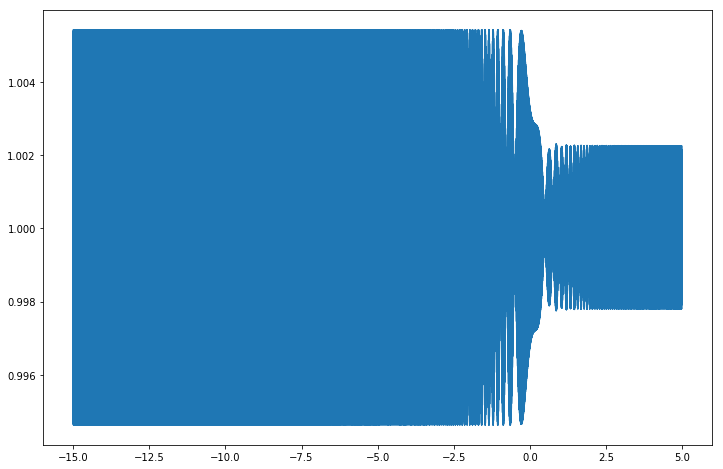

In [9]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t, (np.abs(phi[:,0])**2+np.abs(phi[:,1])**2))

The sum of probabilities should again be zero, but with the unitarity preserving solution it oscillates around zero, instead of walking around as with RK45.

### Analytical Solution
The analytical solution of this for the propability of transition to state $\psi_2$ is given by

$$
    P_d(\tau) = \frac{\omega^2}{2}e^{-\pi\omega^2/4}\left|D_{-1+i\omega^2/2}\left(\tau \sqrt{2} e^{3i\pi/4}\right)\right|^2,
$$

with $\tau = \beta t$, $\omega = \frac{\Omega}{\beta}$. $D_\nu(z)$ is the [**parabolic cylinder function**](https://en.wikipedia.org/wiki/Parabolic_cylinder_function). The derivation is given in the original paper by [**Zener**](http://rspa.royalsocietypublishing.org/content/royprsa/137/833/696.full.pdf) and in a paper by [**Vitanov**](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.53.4288).

In [10]:
from mpmath import pcfd

tAna = np.linspace(-15,5,5000)

tau = beta*tAna
w = Omega(t)/beta
nu = -1+.5j*(w)**2
x = tau*np.sqrt(2)*np.exp(3j*np.pi/4)
factor = ((w**2)/2)*np.exp(-np.pi*w**2/4)

Pfull = factor*np.abs(np.array([complex(pcfd(nu, xi)) for xi in x]))**2

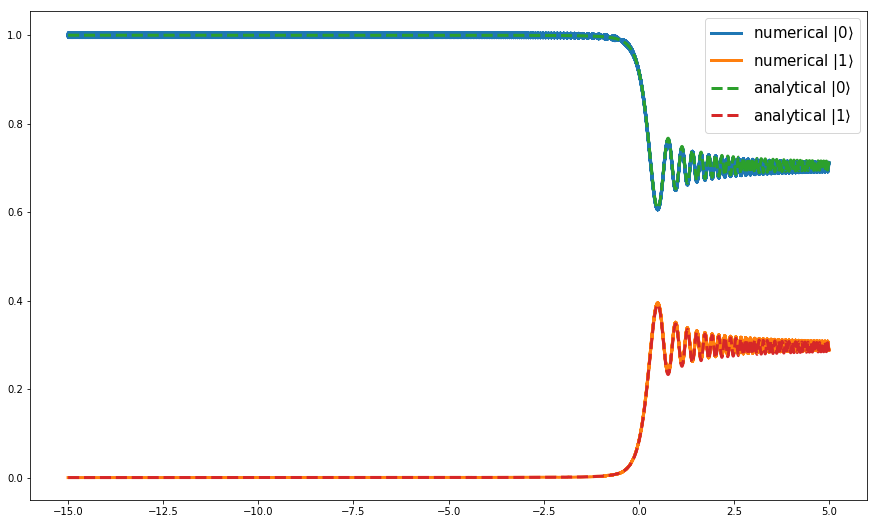

In [11]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phi[:,0])**2, label = r'numerical $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phi[:,1])**2, label = r'numerical $\left|1\right\rangle$', lw = 3)
ax.plot(tAna, 1-Pfull, '--', label = r'analytical $\left|0\right\rangle$', lw = 3)
ax.plot(tAna, Pfull, '--', label = r'analytical $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)

In order to have agreement between the numerical and analytical solution $t_i$ has to be $<<0$, as shown below when we move $t_i$ closer to $0$ the probability at $t=10$ s is different.

In [12]:
beta = 3
Omega = lambda t: 1
Delta = lambda t: beta**2*t

t = np.linspace(-10,10,20001)

phi = np.zeros([len(t),2], dtype = complex)
phi[0,0] = 1
phi[1,0] = 1

Hamiltonians = [None]*t.size
for idt, ti in enumerate(t):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

for idH, H in enumerate(Hamiltonians[2:]):
    phi[idH+2] = propagate(Hamiltonians[idH+1],Hamiltonians[idH],phi[idH+1],phi[idH],dt=np.diff(t)[0])

In [13]:
tau = beta*t
w = Omega(t)/beta
nu = -1+.5j*(w)**2
x = tau*np.sqrt(2)*np.exp(3j*np.pi/4)
factor = ((w**2)/2)*np.exp(-np.pi*w**2/4)

Pfull = factor*np.abs(np.array([complex(pcfd(nu, xi)) for xi in x[::10]]))**2

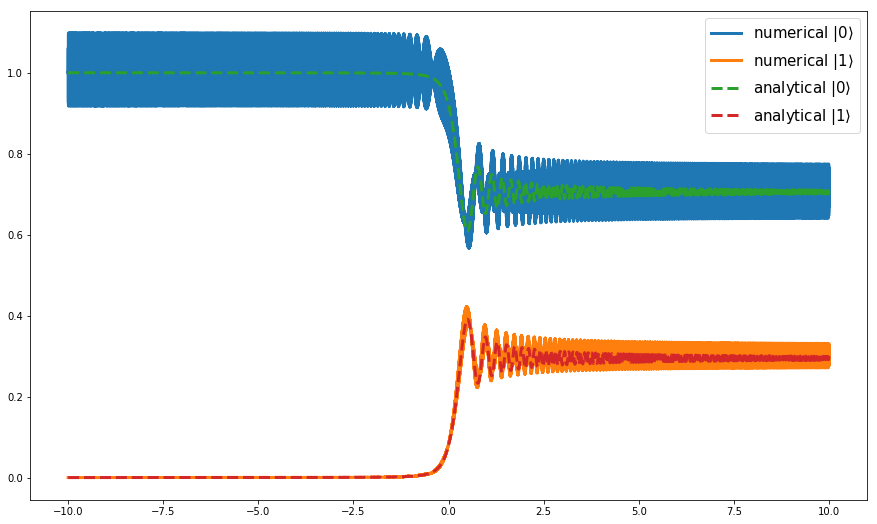

In [14]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phi[:,0])**2, label = r'numerical $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phi[:,1])**2, label = r'numerical $\left|1\right\rangle$', lw = 3)
ax.plot(t[::10], 1-Pfull, '--', label = r'analytical $\left|0\right\rangle$', lw = 3)
ax.plot(t[::10], Pfull, '--', label = r'analytical $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)
# ax.set_yscale('log')

Now the probabilities at $t_f$ do not agree with each other. 

Again the unitarity preserving method has oscillations occuring at $t<0$, which are further dampened when using the non-unitarity preserving RK45 method. The unitarity preserving method is essentially two O(2) integration schemes averaged, so it might be worthwhile to find a higher order unitarity preserving integration scheme.

# Vutha
[**A Simple approach to the Landau-Zener Formula**](http://iopscience.iop.org/article/10.1088/0143-0807/31/2/016/pdf)

System has two basis states $\left|0\right\rangle$ and $\left|1\right\rangle$, and the state vector is

$$
    \left|\psi\right\rangle = \psi_0\left| 0\right\rangle + \psi_1\left|1\right\rangle.
$$

At the initial state for $t=t_i$ the system is in state $\left| 0\right\rangle$ and state $\left| 1\right\rangle$ at energy $\omega_0$ higher than $\left| 0\right\rangle$.

In the rotating wave approximation the Hamiltonian can be written as

$$
    H = \begin{pmatrix}
        0 & \Omega^\dagger e^{+i\omega t} \\
        \Omega e^{-i\omega t} & \omega_0 \\
    \end{pmatrix}
$$

With Zener, where detuning $\Delta = \omega-\omega_0$ is varied linearly with time where $\frac{d}{dt}\Delta(t) = \dot\Delta = \mathrm{constant}$. This is done by varying the pertubation frequency $\omega$ or by tuning the energy level splitting $\omega_0$.

The probability per unit time for excitation out of the $\left| 0\right\rangle$ state is $\Gamma$

$$
    \Gamma = \Omega^2 \frac{\gamma}{\Delta^2+\gamma^2/4},
$$
where $\gamma$ is the decay rate of the Rabi oscillations which is set equal to the inverse dephasing time $\gamma = 1/\tau_D = \sqrt{\frac{\dot\Delta}{4\pi}}$.

Then if $P_0(t)$ is the probability of being in $\left| 0\right\rangle$ at time t, we can write

$$
    P_0(t+\delta t) = \left[1-\Gamma(t)\delta t\right]P_0(t) \approx e^{-\Gamma(t)\delta t}P_0(t)
$$

Integrating this from $t_i$ to $t_f$ results in

$$
    P_0(t_f) = e^{-\int^{t_f}_{t_i}\Gamma(t) dt} = exp\left\{-\frac{2\Omega^2}{\dot\Delta}\left[ \arctan\left(\frac{\Delta(t_f)}{\gamma/2}\right) - \arctan\left(\frac{\Delta(t_i)}{\gamma/2}\right) \right]\right\}
$$

In [15]:
def Ham(t):
    return np.array([[0, Omega(t)*np.exp(1j*omega(t)*t)],
                     [Omega(t)*np.exp(-1j*omega(t)*t), omega0(t)]])

In [16]:
beta = 5

Omega = lambda t: 1
Delta = lambda t: beta*t
omega = lambda t: 1
omega0 = lambda t: omega(t)-Delta(t)

t = np.linspace(-30,30, 50000)

phi = np.zeros([len(t),2], dtype = complex)
phi[0,0] = 1
phi[1,0] = 1

Hamiltonians = [None]*t.size
for idt, ti in enumerate(t):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

for idH, H in enumerate(Hamiltonians[2:]):
    phi[idH+2] = propagate(Hamiltonians[idH+1],Hamiltonians[idH],phi[idH+1],phi[idH],dt=np.diff(t)[0])

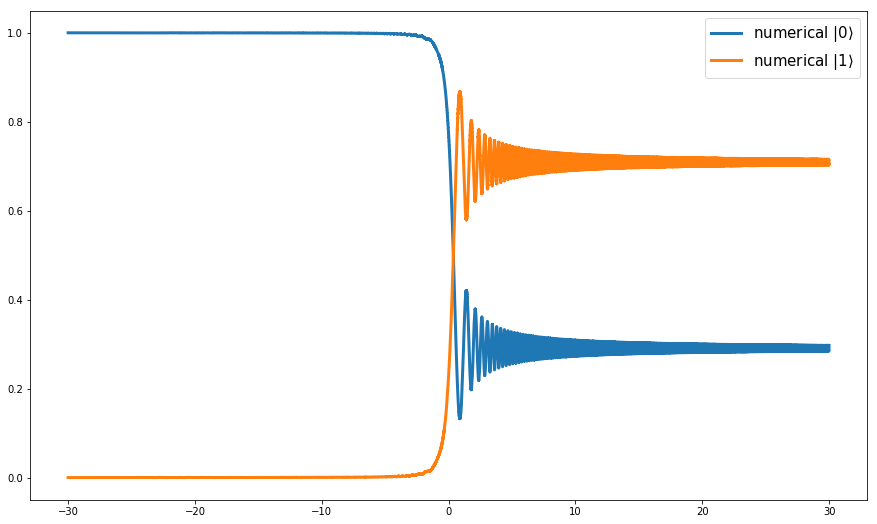

In [17]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phi[:,0])**2, label = r'numerical $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phi[:,1])**2, label = r'numerical $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)

In [18]:
def ProbabilityFinal(Omega, DeltaDot, DeltaTi, DeltaTf, gamma):
    a = -2*Omega**2/DeltaDot
    tf = np.arctan(DeltaTi/(gamma/2))
    ti = np.arctan(DeltaTf/(gamma/2))
    return np.exp(-a*(tf-ti))

In [19]:
DeltaDot = Delta(1)
gamma = np.sqrt(DeltaDot/(4*np.pi))

P = ProbabilityFinal(Omega(1), DeltaDot, Delta(t.min()), 
                                    Delta(t), gamma)

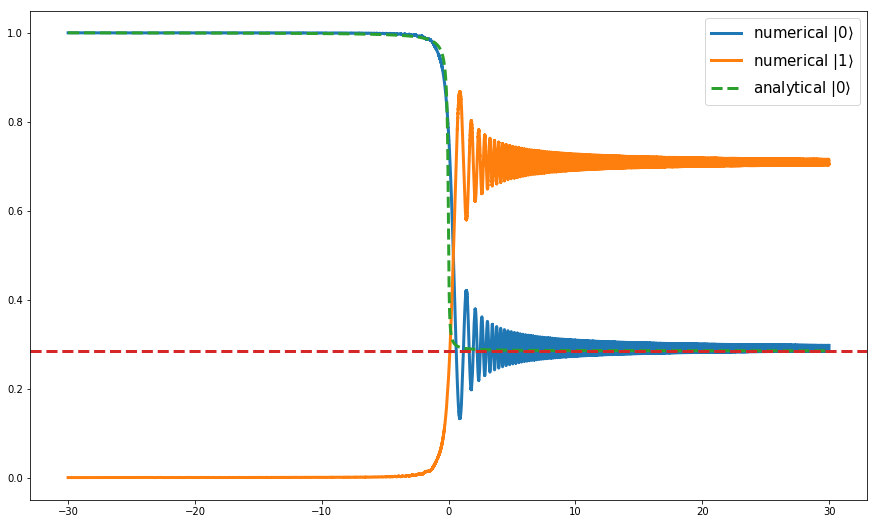

In [20]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phi[:,0])**2, label = r'numerical $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phi[:,1])**2, label = r'numerical $\left|1\right\rangle$', lw = 3)
ax.plot(t, P, '--', label = r'analytical $\left|0\right\rangle$', lw = 3)
ax.axhline(np.exp(-2*np.pi*Omega(1)**2/Delta(1)), ls = '--', lw = 3, color = 'C3')
ax.legend(fontsize = 15)

# Vectorizing the Numerical Integration

For now we had a for loop integrating over the O.D.E. system, but this should be able to be sped up considerably by vectorizing the equation.
$$
\psi_{n+1} = \left(\frac{4}{i\Delta t \hat{H}_n +2}+\frac{4}{i\Delta t \hat{H}_{n-1}-2}\right)\psi_n+\psi_{n-1}
$$

In [21]:
def Ham(t):
    return np.array([[0, Omega(t)*np.exp(1j*omega(t)*t)],
                     [Omega(t)*np.exp(-1j*omega(t)*t), omega0(t)]])

In [22]:
def propagate(H1,H2,phi1,phi2,dt):
    a = 4/(1j*H1*dt+2)
    b = 4/(1j*H2*dt-2)
    return (a+b)@phi1+phi2

In [23]:
beta = 5

Omega = lambda t: 1
Delta = lambda t: beta*t
omega = lambda t: 1
omega0 = lambda t: omega(t)-Delta(t)

t = np.linspace(-15,10, 40000)

phi = np.zeros([len(t),2], dtype = complex)
phi[0,0] = 1
phi[1,0] = 1

Hamiltonians = [None]*t.size
for idt, ti in enumerate(t):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

for idH, H in enumerate(Hamiltonians[2:]):
    phi[idH+2] = propagate(Hamiltonians[idH+1],Hamiltonians[idH],phi[idH+1],phi[idH],dt=np.diff(t)[0])

In [24]:
dt = np.diff(t)[0]
a = 4/(1j*Hamiltonians[1:-1]*dt + 2)
b = 4/(1j*Hamiltonians[:-2]*dt - 2)

In [25]:
phi[2:] = np.einsum('kij,ki->kj',a+b,phi[1:-1])+phi[:-2]

In [26]:
phi

array([[ 1.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 1.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
       [ 1.00000000e+00+0.j        , -8.13176466e-04+0.00094938j],
       ...,
       [ 5.52354510e-01+0.0636854j ,  8.08148203e-01+0.19460897j],
       [ 5.51462880e-01+0.06421519j,  8.02199399e-01+0.21935196j],
       [ 5.51565326e-01+0.06444764j,  7.95017864e-01+0.24439438j]])

### Testing Einsum
I realized far too late that this will not work because I need numerical integration, which means I don't know all values of $\psi$ yet...

In [27]:
A = np.array([1,2])
B = np.array([[1,2],[3,4]])
A@B

array([ 7, 10])

In [28]:
np.einsum('ij,i',B,A)

array([ 7, 10])

In [29]:
Avec = np.array([A]*5)
Bvec = np.array([B]*5)

In [30]:
np.einsum('kij,ki->kj',Bvec,Avec)

array([[ 7, 10],
       [ 7, 10],
       [ 7, 10],
       [ 7, 10],
       [ 7, 10]])

# Using Cython to speed up numerical integration

In [31]:
%load_ext Cython

In [32]:
%%cython --force --annotate
cimport cython
import numpy
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def propagateCython(H, phi, dt):
    cdef int nrValues = len(H)
    a = 4/(1j*H[1:nrValues-1]*dt+2)
    b = 4/(1j*H[:nrValues-2]*dt-2)
    cdef np.ndarray[np.complex_t, ndim=3] c = a+b
    cdef np.ndarray[np.complex_t, ndim=2] phiC = phi
    cdef double dtC = dt
    cdef int i
    for i in range(nrValues-2):
        phiC[i+2] = c[i]@phiC[i+1]+phiC[i]
    return phiC

Yellow lines indicate `Python` interaction, which slows down the numerical integration. Optimizing anything outside of the for loop is pointless, since most time is spent in the for loop anyway. For some reason `Cython` still has `Python` interaction for array manipulation, even though I converted the arrays into `C` arrays.

Writing a pure `C` or `C++` function for the numerical integration and interfacing through `Cython` should solve this problem.

In [33]:
dt = np.diff(t)[0]

In [34]:
%timeit -n2 propagateCython(Hamiltonians, phi, dt)

117 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [35]:
%%timeit -n2
for idH, H in enumerate(Hamiltonians[2:]):
    phi[idH+2] = propagate(Hamiltonians[idH+1],Hamiltonians[idH],phi[idH+1],phi[idH],dt=dt)

705 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


With `Cython` the numerical integration is sped up by roughly a factor 8. A pure `C` or `C++` function should give an even larger speed increase.

In [36]:
phiCython = propagateCython(Hamiltonians, phi, dt)

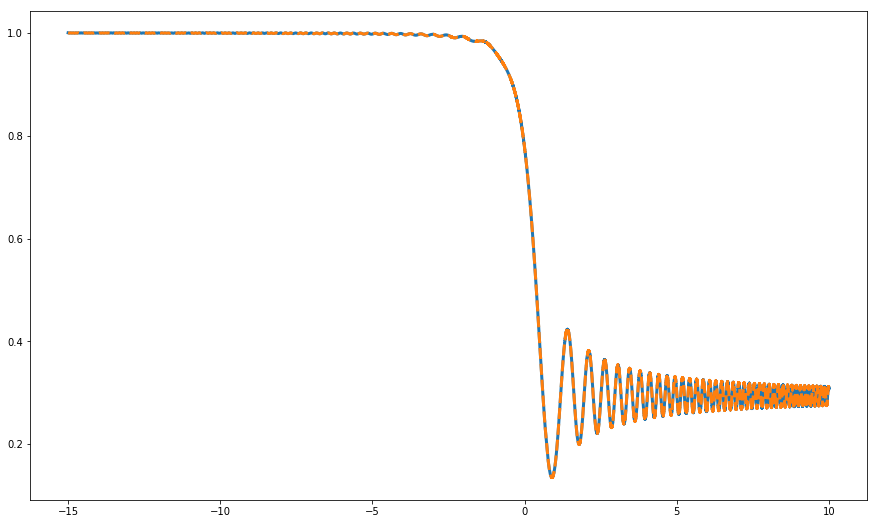

In [37]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phiCython[:,0])**2, lw = 3)
ax.plot(t, np.abs(phi[:,0])**2, '--', lw = 3)

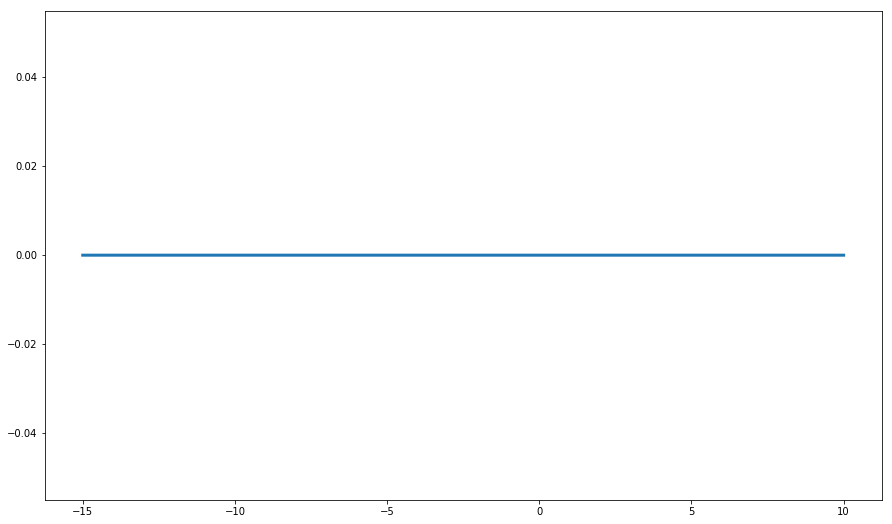

In [38]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phiCython[:,0])**2-np.abs(phi[:,0])**2, lw = 3)

# Adams-Bashforth Method

See [Wikipedia](https://en.wikipedia.org/wiki/Linear_multistep_method#Adams%E2%80%93Bashforth_methods).
$$
\begin{align}
y_{n+1} &= y_n + hf(t_n, y_n) , \qquad\text{(This is the Euler method)} \\
y_{n+2} &= y_{n+1} + h\left( \frac{3}{2}f(t_{n+1}, y_{n+1}) - \frac{1}{2}f(t_n, y_n) \right) , \\
y_{n+3} &= y_{n+2} + h\left( \frac{23}{12} f(t_{n+2}, y_{n+2}) - \frac{4}{3} f(t_{n+1}, y_{n+1}) + \frac{5}{12}f(t_n, y_n)\right) , \\
y_{n+4} &= y_{n+3} + h\left( \frac{55}{24} f(t_{n+3}, y_{n+3}) - \frac{59}{24} f(t_{n+2}, y_{n+2}) + \frac{37}{24} f(t_{n+1}, y_{n+1}) - \frac{3}{8} f(t_n, y_n) \right) , \\
y_{n+5} &= y_{n+4} + h\left( \frac{1901}{720} f(t_{n+4}, y_{n+4}) - \frac{1387}{360} f(t_{n+3}, y_{n+3}) + \frac{109}{30} f(t_{n+2}, y_{n+2}) - \frac{637}{360} f(t_{n+1}, y_{n+1}) + \frac{251}{720} f(t_n, y_n) \right)
\end{align}
$$

In [39]:
def propagateAdamsBashforth(Hamiltonians,phi0,dt):
    phi = np.zeros([len(Hamiltonians), len(phi0)], dtype = complex)
    phi[0] = phi0
    a0 = 3/2
    a1 = 1/2
    b0 = 23/12
    b1 = 4/3
    b2 = 5/12
    c0 = 55/24
    c1 = 59/24
    c2 = 37/24
    c3 = 3/8
    d0 = 1901/720
    d1 = 1387/360
    d2 = 109/30
    d3 = 637/360
    d4 = 251/720
    c = 1/(1j)
    
    f = [None]*len(phi)
    
    f0 = c*Hamiltonians[0]@phi[0]
    phi[1] = phi[0]+dt*f0
    f1 = c*Hamiltonians[1]@phi[1]
    phi[2] = phi[1]+dt*(a0*f1-a1*f0)
    f2 = c*Hamiltonians[2]@phi[2]
    phi[3] = phi[2]+dt*(b0*f2-b1*f1+b2*f0)
    f3 = c*Hamiltonians[3]@phi[3]
    phi[4] = phi[3]+dt*(c0*f3-c1*f2+c2*f1-c3*f0)
    
    f[0] = f0
    f[1] = f1
    f[2] = f2
    f[3] = f3
    
    for idx in range(4,len(phi)-1):
        f[idx] = c*Hamiltonians[idx]@phi[idx]
        df = d0*f[idx]-d1*f[idx-1]+d2*f[idx-2]-d3*f[idx-3]+d4*f[idx-4]
        phi[idx+1] = phi[idx]+dt*df
    return phi

In [40]:
beta = 5

Omega = lambda t: 1
Delta = lambda t: beta*t
omega = lambda t: 1
omega0 = lambda t: omega(t)-Delta(t)

tAdams = np.linspace(-15,10, 40000)

phi = np.zeros([len(tAdams),2], dtype = complex)
phi[0,0] = 1
phi[1,0] = 1

Hamiltonians = [None]*t.size
for idt, ti in enumerate(tAdams):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

for idH, H in enumerate(Hamiltonians[2:]):
    phi[idH+2] = propagate(Hamiltonians[idH+1],Hamiltonians[idH],phi[idH+1],phi[idH],dt=np.diff(t)[0])

In [41]:
phiAdams = propagateAdamsBashforth(Hamiltonians, np.array([1,0]), dt)

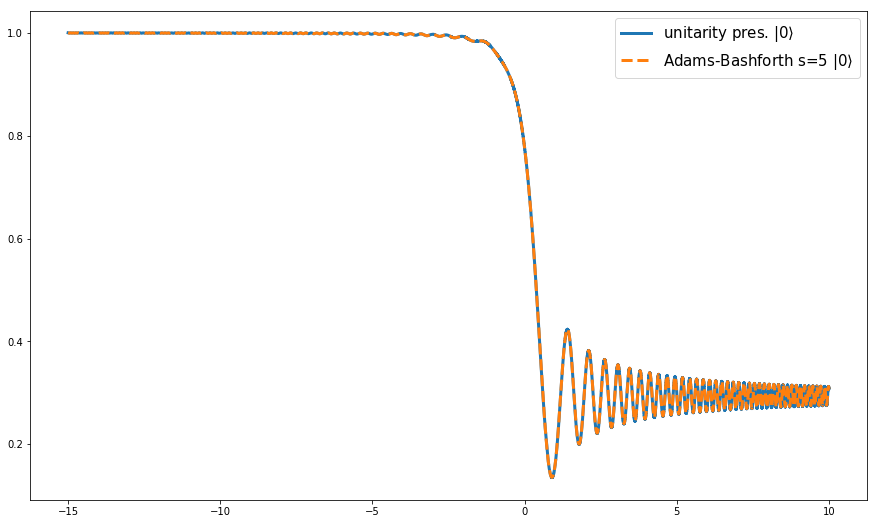

In [42]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phiCython[:,0])**2, lw = 3, 
        label = r'unitarity pres. $\left|0\right\rangle$')
ax.plot(tAdams, np.abs(phiAdams[:,0])**2, '--', lw = 3, 
        label = r'Adams-Bashforth s=5 $\left|0\right\rangle$')
ax.legend(fontsize = 15)

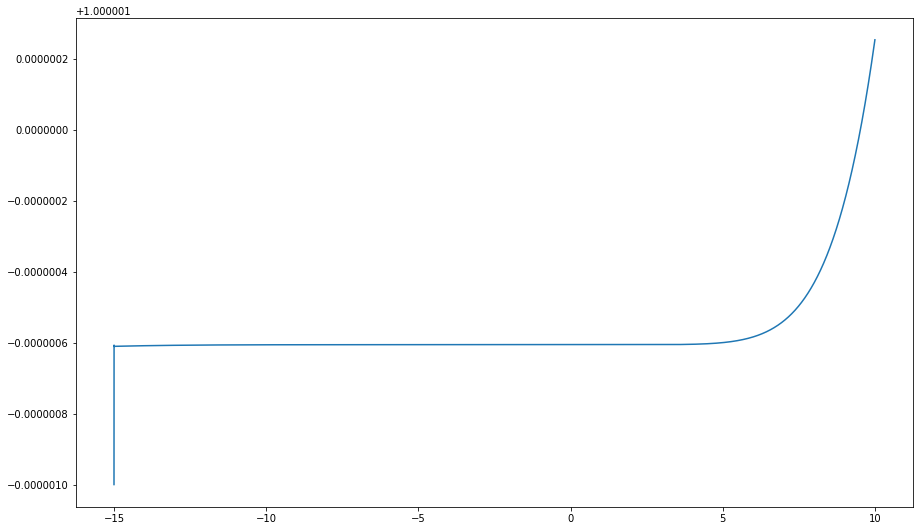

In [43]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tAdams, np.sum(np.abs(phiAdams)**2, axis = 1 ))

In [44]:
%%cython --force --annotate
cimport cython
import numpy
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def propagateCythonAdamsBashforth(H, phi0, dt):
    cdef int nrValues = len(H)
    cdef np.ndarray[np.complex_t, ndim=2] f = numpy.zeros([nrValues,2], dtype = complex)
    cdef np.ndarray[np.complex_t, ndim=2] phiC = numpy.zeros([nrValues,2], dtype = complex)
    phiC[0] = phi0
    cdef double dtC = dt
    cdef int i
    
    cdef double a0 = 3/2
    cdef double a1 = 1/2
    cdef double b0 = 23/12
    cdef double b1 = 4/3
    cdef double b2 = 5/12
    cdef double c0 = 55/24
    cdef double c1 = 59/24
    cdef double c2 = 37/24
    cdef double c3 = 3/8
    cdef double d0 = 1901/720
    cdef double d1 = 1387/360
    cdef double d2 = 109/30
    cdef double d3 = 637/360
    cdef double d4 = 251/720
    cdef complex c = 1/(1j)
    
    f[0] = c*H[0]@phiC[0]
    phiC[1] = phiC[0]+dtC*f[0]
    f[1] = c*H[1]@phiC[1]
    phiC[2] = phiC[1]+dtC*(a0*f[1]-a1*f[0])
    f[2] = c*H[2]@phiC[2]
    phiC[3] = phiC[2]+dtC*(b0*f[2]-b1*f[1]+b2*f[0])
    f[3] = c*H[3]@phiC[3]
    phiC[4] = phiC[3]+dtC*(c0*f[3]-c1*f[2]+c2*f[1]-c3*f[0])
    
    for idx in range(4,nrValues-1):
        f[idx] = c*H[idx]@phiC[idx]
        df = d0*f[idx]-d1*f[idx-1]+d2*f[idx-2]-d3*f[idx-3]+d4*f[idx-4]
        phiC[idx+1] = phiC[idx]+dtC*df
    return phiC

In [45]:
%timeit -n2 propagateAdamsBashforth(Hamiltonians, np.array([1,0]), dt)

670 ms ± 8.34 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [46]:
%timeit -n2 propagateCythonAdamsBashforth(Hamiltonians, np.array([1,0]), dt)

662 ms ± 5.02 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [47]:
def propagateAdamsBashforth4(Hamiltonians,phi0,dt):
    phi = np.zeros([len(Hamiltonians), len(phi0)], dtype = complex)
    phi[0] = phi0
    a0 = 3/2
    a1 = 1/2
    b0 = 23/12
    b1 = 4/3
    b2 = 5/12
    c0 = 55/24
    c1 = 59/24
    c2 = 37/24
    c3 = 3/8
    c = 1/(1j)
    
    f = [None]*len(phi)
    
    f0 = c*Hamiltonians[0]@phi[0]
    phi[1] = phi[0]+dt*f0
    f1 = c*Hamiltonians[1]@phi[1]
    phi[2] = phi[1]+dt*(a0*f1-a1*f0)
    f2 = c*Hamiltonians[2]@phi[2]
    phi[3] = phi[2]+dt*(b0*f2-b1*f1+b2*f0)
    f3 = c*Hamiltonians[3]@phi[3]
    phi[4] = phi[3]+dt*(c0*f3-c1*f2+c2*f1-c3*f0)
    
    f[0] = f0
    f[1] = f1
    f[2] = f2
    f[3] = f3
    
    for idx in range(4,len(phi)-1):
        f[idx] = c*Hamiltonians[idx]@phi[idx]
        df = c0*f[idx]-c1*f[idx-1]+c2*f[idx-2]-c3*f[idx-3]
        phi[idx+1] = phi[idx]+dt*df
    return phi

In [48]:
%timeit -n2 propagateAdamsBashforth4(Hamiltonians, np.array([1,0]), dt)

581 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [49]:
phiAdams4 = propagateAdamsBashforth4(Hamiltonians, np.array([1,0]), dt)

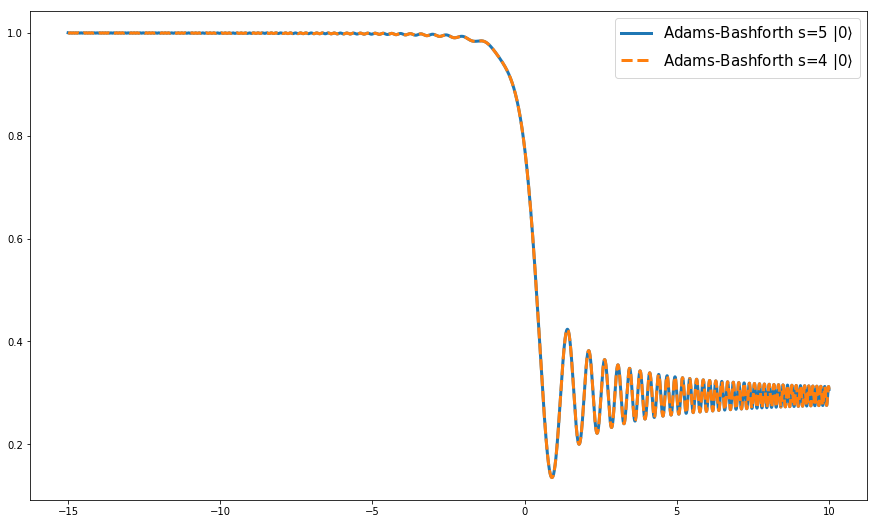

In [50]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phiAdams[:,0])**2, lw = 3, 
        label = r'Adams-Bashforth s=5 $\left|0\right\rangle$')
ax.plot(tAdams, np.abs(phiAdams4[:,0])**2, '--', lw = 3, 
        label = r'Adams-Bashforth s=4 $\left|0\right\rangle$')
ax.legend(fontsize = 15)

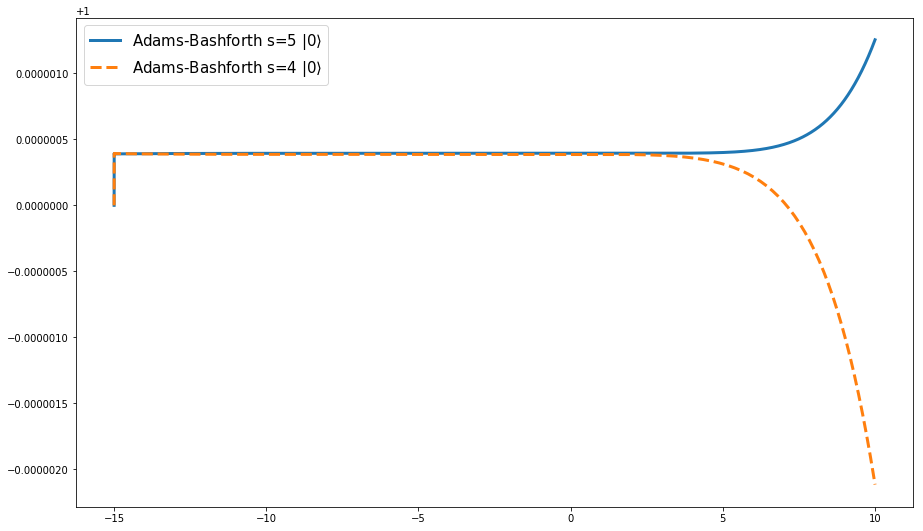

In [51]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.sum(np.abs(phiAdams)**2, axis = 1), lw = 3, 
        label = r'Adams-Bashforth s=5 $\left|0\right\rangle$')
ax.plot(tAdams, np.sum(np.abs(phiAdams4)**2, axis = 1), '--', lw = 3, 
        label = r'Adams-Bashforth s=4 $\left|0\right\rangle$')
ax.legend(fontsize = 15)

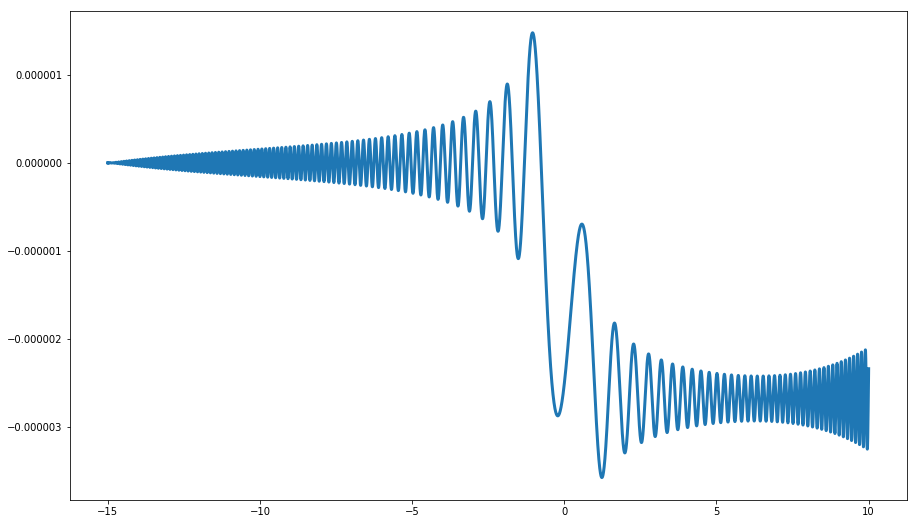

In [52]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tAdams, np.abs(phiAdams4[:,0])**2-np.abs(phiAdams[:,0])**2, lw = 3)

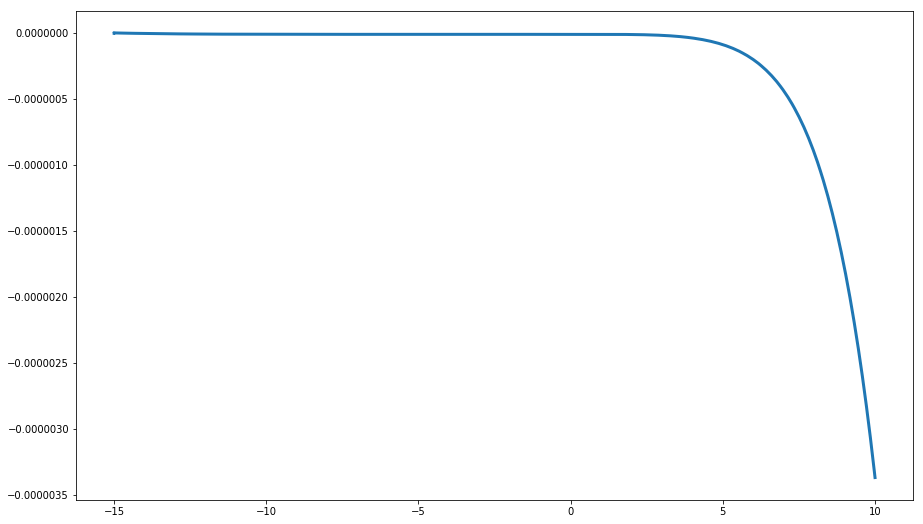

In [53]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tAdams, np.sum(np.abs(phiAdams4)**2, axis = 1) -
                np.sum(np.abs(phiAdams)**2, axis = 1 ), lw = 3 )

In [54]:
def propagateAdamsBashforth3(Hamiltonians,phi0,dt):
    phi = np.zeros([len(Hamiltonians), len(phi0)], dtype = complex)
    phi[0] = phi0
    a0 = 3/2
    a1 = 1/2
    b0 = 23/12
    b1 = 4/3
    b2 = 5/12
    c = 1/(1j)
    
    f = [None]*len(phi)
    
    f0 = c*Hamiltonians[0]@phi[0]
    phi[1] = phi[0]+dt*f0
    f1 = c*Hamiltonians[1]@phi[1]
    phi[2] = phi[1]+dt*(a0*f1-a1*f0)
    f2 = c*Hamiltonians[2]@phi[2]
    phi[3] = phi[2]+dt*(b0*f2-b1*f1+b2*f0)
    
    f[0] = f0
    f[1] = f1
    f[2] = f2
    
    for idx in range(3,len(phi)-1):
        f[idx] = c*Hamiltonians[idx]@phi[idx]
        df = b0*f[idx]-b1*f[idx-1]+b2*f[idx-2]
        phi[idx+1] = phi[idx]+dt*df
    return phi

In [55]:
%timeit -n2 propagateAdamsBashforth3(Hamiltonians, np.array([1,0]), dt)

499 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [56]:
phiAdams3 = propagateAdamsBashforth3(Hamiltonians, np.array([1,0]), dt)

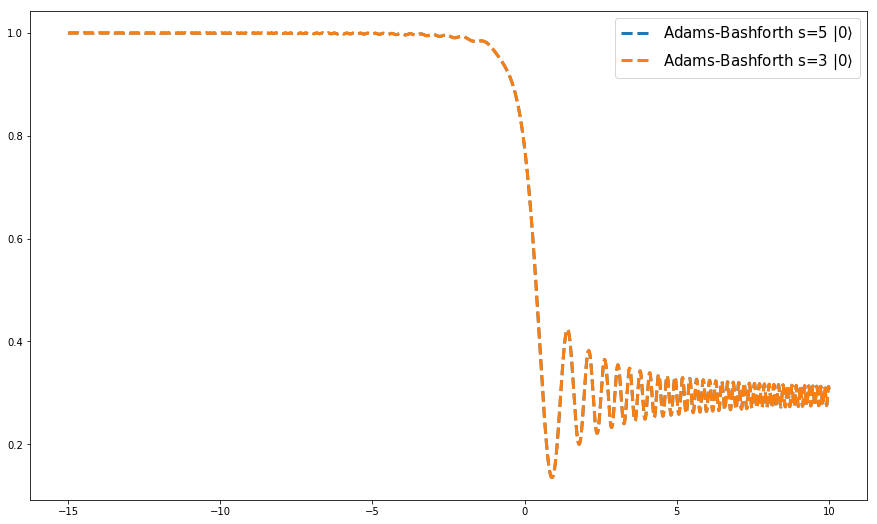

In [57]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tAdams, np.abs(phiAdams[:,0])**2, '--', lw = 3, 
        label = r'Adams-Bashforth s=5 $\left|0\right\rangle$')
ax.plot(tAdams, np.abs(phiAdams4[:,0])**2, '--', lw = 3, 
        label = r'Adams-Bashforth s=3 $\left|0\right\rangle$')
ax.legend(fontsize = 15)

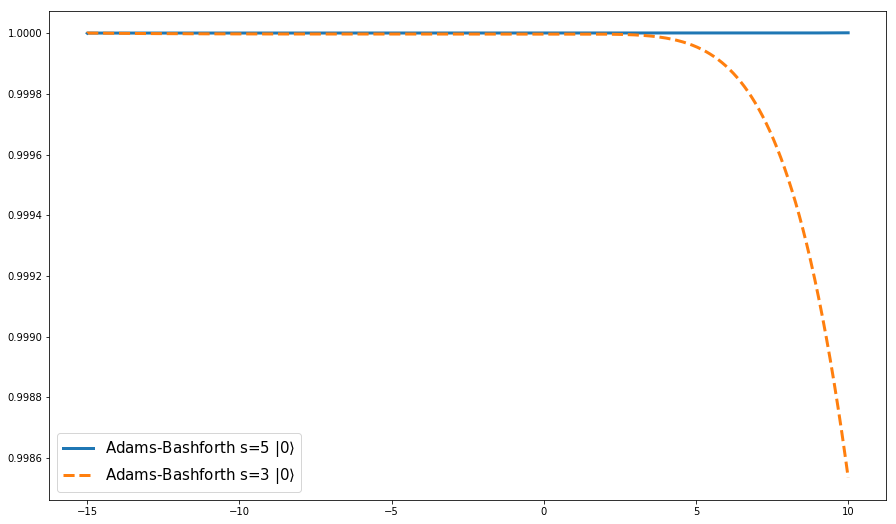

In [58]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.sum(np.abs(phiAdams)**2, axis = 1), lw = 3, 
        label = r'Adams-Bashforth s=5 $\left|0\right\rangle$')
ax.plot(tAdams, np.sum(np.abs(phiAdams3)**2, axis = 1), '--', lw = 3, 
        label = r'Adams-Bashforth s=3 $\left|0\right\rangle$')
ax.legend(fontsize = 15)

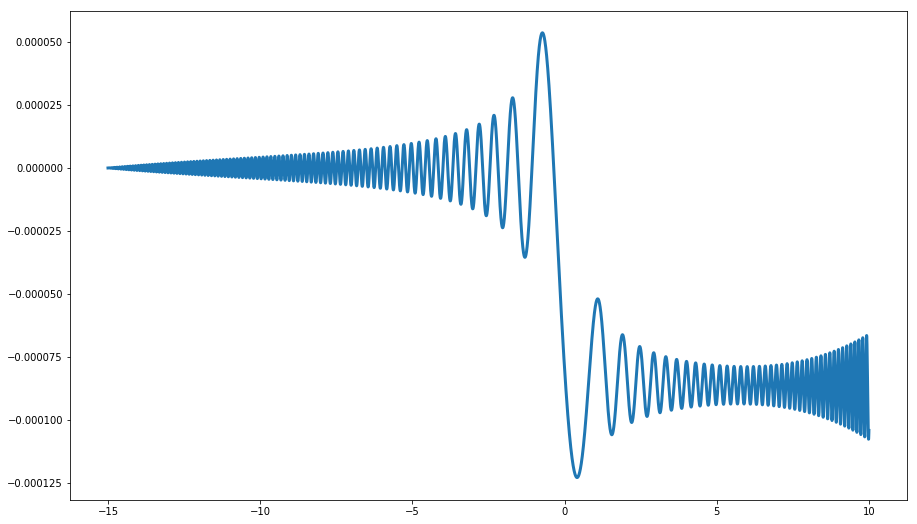

In [59]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(tAdams, np.abs(phiAdams3[:,0])**2-np.abs(phiAdams[:,0])**2, lw = 3)

# Exponent Method

In [60]:
def Ham(t):
    return np.array([[0, Omega(t)*np.exp(1j*omega(t)*t)],
                     [Omega(t)*np.exp(-1j*omega(t)*t), omega0(t)]])

In [61]:
from scipy.linalg import expm
def propagateExp(Hamiltonians, phi0, dt):
    phi = np.zeros([len(Hamiltonians), len(phi0)], dtype = complex)
    phi[0] = phi0
    
    for idH, H in enumerate(Hamiltonians[:-1]):
        phi[idH+1] = expm(-1j*H*dt)@phi[idH]
    return phi

In [62]:
beta = 5

Omega = lambda t: 1
Delta = lambda t: beta*t
omega = lambda t: 1
omega0 = lambda t: omega(t)-Delta(t)

t = np.linspace(-30,30, 20000)
dt = np.diff(t)[0]
phi0 = np.array([1,0], dtype = complex)

Hamiltonians = [None]*t.size
for idt, ti in enumerate(t):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

phi = propagateExp(Hamiltonians, phi0, dt)

In [63]:
DeltaDot = Delta(1)
gamma = np.sqrt(DeltaDot/(4*np.pi))

P = ProbabilityFinal(Omega(1), DeltaDot, Delta(t.min()), 
                                    Delta(t), gamma)

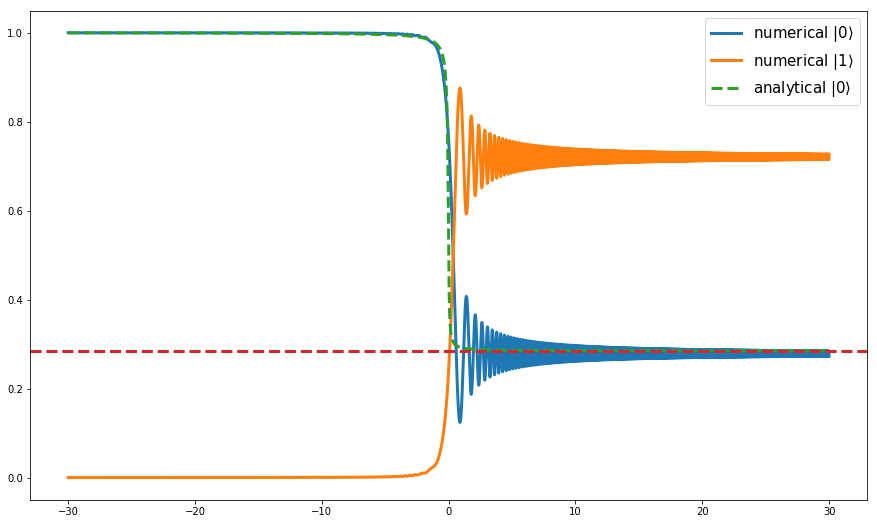

In [64]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phi[:,0])**2, label = r'numerical $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phi[:,1])**2, label = r'numerical $\left|1\right\rangle$', lw = 3)
ax.plot(t, P, '--', label = r'analytical $\left|0\right\rangle$', lw = 3)
ax.axhline(np.exp(-2*np.pi*Omega(1)**2/Delta(1)), ls = '--', lw = 3, color = 'C3')
ax.legend(fontsize = 15)

In [65]:
np.sum(np.abs(phi)**2, axis = 1)

array([1., 1., 1., ..., 1., 1., 1.])

# RK4 Method

Should give less oscillations, but is unfortunately not unitarity conserving. However, considering how much the solution oscillates for certain boundary conditions with the unitarity conserving method this might prove more stable.

The 4th order Runge-Kutta method is a solution to the problem

$$
    \dot{y} = f(t, y), \quad y(t_0) = y_0.
$$

The solution is given by

$$
    y_{n+1} = y_n + \frac{1}{6}\left(k_1 + 2k_2 + 2k_3 + k_4 \right),
$$

where 
$$
    \begin{align}
         k_1 &= h \ f(t_n, y_n), \\
         k_2 &= h \ f\left(t_n + \frac{h}{2}, y_n + \frac{k_1}{2}\right), \\
         k_3 &= h \ f\left(t_n + \frac{h}{2}, y_n + \frac{k_2}{2}\right), \\
         k_4 &= h \ f\left(t_n + h, y_n + k_3\right).
    \end{align}
$$

For the Schroedinger equation

$$
    i\frac{\delta}{\delta t}\left|\psi(t)\right\rangle = H(t)\left|\psi(t)\right\rangle,
$$
$f = \frac{H(t)}{i}\left|\psi(t)\right\rangle$.

# Magnus Expansion Numerical Integrator

For a differential equation of form

$$
    y'(t) = a(t)y(t),
$$

using the [**Magnus Expansion**](https://en.wikipedia.org/wiki/Magnus_expansion) in [**numerical form**](https://link.springer.com/content/pdf/10.1023%2FA%3A1022393913721.pdf). With

$$
\begin{align}
    a_1 &= a\left(t_n + \left(\frac{1}{2}-\frac{\sqrt{3}}{6}\right)h\right),\\
    a_2 &= a\left(t_n + \left(\frac{1}{2}+\frac{\sqrt{3}}{6}\right)h\right),
\end{align}
$$
where $h$ is the step size, and
$$
    \sigma^n = \frac{1}{2}h\left(a_1+a_2\right)+\frac{\sqrt{3}}{12}h^2[a_2,a_1].
$$

We finally get

$$
    y_{n+1} = e^{\sigma^n}y_n
$$


In [66]:
from scipy.linalg import expm
def propagateMagnus4thHamFun(HamFun, t, phi0, dt):
    phi = np.zeros([len(t), len(phi0)], dtype = complex)
    phi[0] = phi0
    
    c = np.sqrt(3)/6
    d = np.sqrt(3)/12
    for idT, ti in enumerate(t[:-1]):
        a1 = HamFun(ti+(0.5-c)*dt)
        a2 = HamFun(ti+(0.5+c)*dt)
        sigma = 0.5*dt*(a1+a2)+d*(dt**2)*(a2@a1-a1@a2)
        phi[idT+1] = expm(sigma)@phi[idT]
    return phi

In [67]:
def propagateAdamsBashforthNoComplex(Hamiltonians,phi0,dt):
    phi = np.zeros([len(Hamiltonians), len(phi0)], dtype = complex)
    phi[0] = phi0
    a0 = 3/2
    a1 = 1/2
    b0 = 23/12
    b1 = 4/3
    b2 = 5/12
    c0 = 55/24
    c1 = 59/24
    c2 = 37/24
    c3 = 3/8
    d0 = 1901/720
    d1 = 1387/360
    d2 = 109/30
    d3 = 637/360
    d4 = 251/720
    c = 1
    
    f = [None]*len(phi)
    
    f0 = c*Hamiltonians[0]@phi[0]
    phi[1] = phi[0]+dt*f0
    f1 = c*Hamiltonians[1]@phi[1]
    phi[2] = phi[1]+dt*(a0*f1-a1*f0)
    f2 = c*Hamiltonians[2]@phi[2]
    phi[3] = phi[2]+dt*(b0*f2-b1*f1+b2*f0)
    f3 = c*Hamiltonians[3]@phi[3]
    phi[4] = phi[3]+dt*(c0*f3-c1*f2+c2*f1-c3*f0)
    
    f[0] = f0
    f[1] = f1
    f[2] = f2
    f[3] = f3
    
    for idx in range(4,len(phi)-1):
        f[idx] = c*Hamiltonians[idx]@phi[idx]
        df = d0*f[idx]-d1*f[idx-1]+d2*f[idx-2]-d3*f[idx-3]+d4*f[idx-4]
        phi[idx+1] = phi[idx]+dt*df
    return phi

In [68]:
def propagateExpNoComplex(Hamiltonians, phi0, dt):
    phi = np.zeros([len(Hamiltonians), len(phi0)])
    phi[0] = phi0
    
    for idH, H in enumerate(Hamiltonians[:-1]):
        phi[idH+1] = expm(H*dt)@phi[idH]
    return phi

### Testcase 1

First testing the equation

$$
    y'(t) = a(t)y(t),
$$
with 

$$
    a(t) = \begin{bmatrix}
        100t & 0 \\
        0    & -100 \\
    \end{bmatrix}.
$$

For $y(0) = [1,1]^T$ the solution is

$$
    y(t) = \begin{pmatrix}
        e^{50t^2}\\
        e^{-100 t}
    \end{pmatrix}.
$$

Below I've tested several methods of numerical integration to check fidelity.

In [69]:
def solAna(t):
    y0 = np.exp(50*t**2)
    y1 = np.exp(-100*t)
    return [y0,y1]

In [70]:
def differentialEquation(t, c):
    c1 = 100*c[0]*t
    c2 = -100*c[1]
    return [c1, c2]

In [71]:
def Ham(t):
    return np.array([[100*t,0],[0,-100]])

In [72]:
dt = 1e-4

t = np.arange(0,0.5,dt)

Hamiltonians = [None]*t.size
for idt, ti in enumerate(t):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

In [73]:
phi = propagateMagnus4thHamFun(Ham, t, np.array([1,1]), dt)
phiAdams = propagateAdamsBashforthNoComplex(Hamiltonians, np.array([1,1]), dt)
phiExp = propagateExpNoComplex(Hamiltonians, np.array([1,1]), dt)
sol = solve_ivp(differentialEquation, [t.min(), t.max()], [1,1], t_eval=t, vectorized = True)

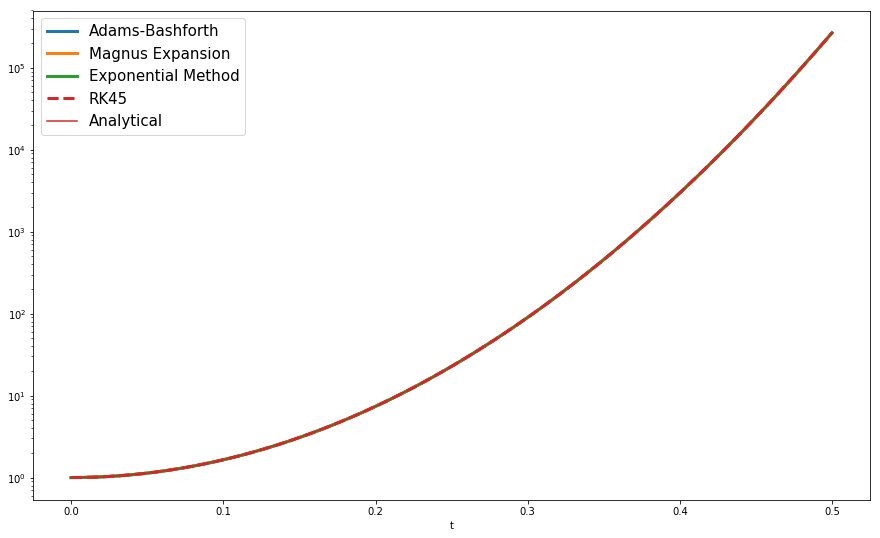

In [74]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phiAdams[:,0]), lw = 3, label = 'Adams-Bashforth')
ax.plot(t, np.abs(phi[:,0]), lw = 3, label = 'Magnus Expansion')
ax.plot(t, np.abs(phiExp[:,0]), lw = 3, label = 'Exponential Method')
ax.plot(sol.t, np.abs(sol.y[0]), 'C3--', lw = 3, label = 'RK45')
ax.plot(t, np.exp(50*t**2), label = 'Analytical')
ax.legend(fontsize = 15)
ax.set_yscale('log')
ax.set_xlabel('t');

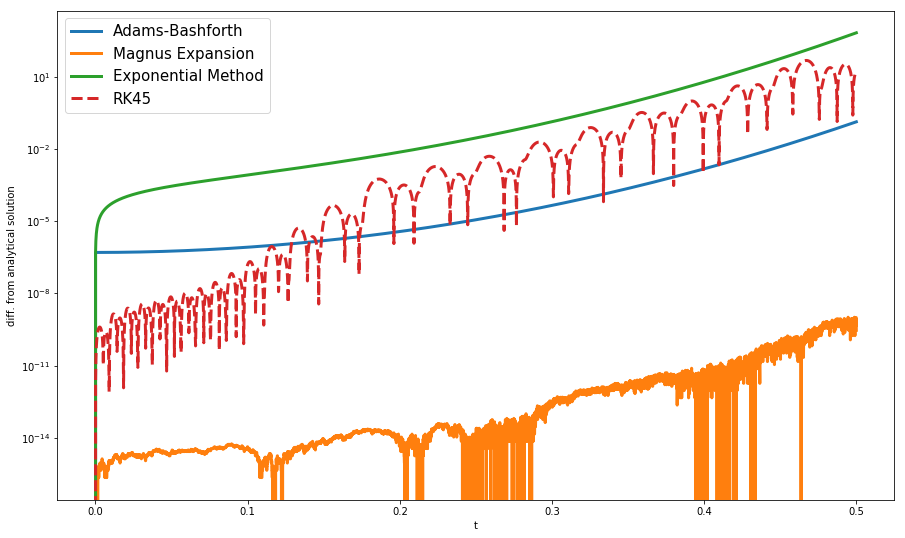

In [75]:
yi = 0
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(solAna(t)[yi]-np.real(phiAdams[:,yi])), lw = 3, label = 'Adams-Bashforth')
ax.plot(t, np.abs(solAna(t)[yi]-np.real(phi[:,yi])), lw = 3, label = 'Magnus Expansion')
ax.plot(t, np.abs(solAna(t)[yi]-np.real(phiExp[:,yi])), lw = 3, label = 'Exponential Method')
ax.plot(sol.t, np.abs(solAna(t)[yi]-np.abs(sol.y[yi])), 'C3--', lw = 3, label = 'RK45')
ax.legend(fontsize = 15)
ax.set_yscale('log')
ax.set_ylabel('diff. from analytical solution');
ax.set_xlabel('t');

Clearly the Magnus Expansion numerical integrator gives much better fidelity, by up to O(5).

### Testcase 2

Now testing

$$
    y'(t) = a(t)y(t),
$$
with 

$$
    a(t) = \begin{bmatrix}
        -1000t & 1 \\
        0    & -t \\
    \end{bmatrix}.
$$

For $y(0) = [-1,1]^T$ the solution is

$$
    y(t) = \begin{pmatrix}
        \frac{1}{666}e^{-500t^2}\left[-666+\sqrt{222\pi}\text{Erfi}\left(3\sqrt{\frac{111}{2}}t\right)\right]\\
        e^{-\frac{t^2}{2}}
    \end{pmatrix}.
$$

In [76]:
def differentialEquation(t, c):
    c0 = -1000*c[0]*t+c[1]
    c1 = -t*c[1]
    return [c0, c1]

In [77]:
def Ham(t):
    return np.array([[-1000*t,1],[0,-t]])

In [78]:
from scipy.special import erfi
def solAna(t):
    y0 = (1/666)*np.exp(-500*t**2)*(-666+np.sqrt(222*np.pi)*erfi(3*np.sqrt(111/2)*t))
    y1 = np.exp(-0.5*t**2)
    return [y0, y1]

In [79]:
dt = 1e-4

t = np.arange(0,5,dt)

Hamiltonians = [None]*t.size
for idt, ti in enumerate(t):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

In [80]:
phi = propagateMagnus4thHamFun(Ham, t, np.array([-1,1], dtype = complex), dt)
phiAdams = propagateAdamsBashforthNoComplex(Hamiltonians, np.array([-1,1], dtype = complex), dt)
phiExp = propagateExpNoComplex(Hamiltonians, np.array([-1,1]), dt)
sol = solve_ivp(differentialEquation, [t.min(), t.max()], [-1,1], t_eval=t, vectorized = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in subtract
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


(-1.05, 0.05)

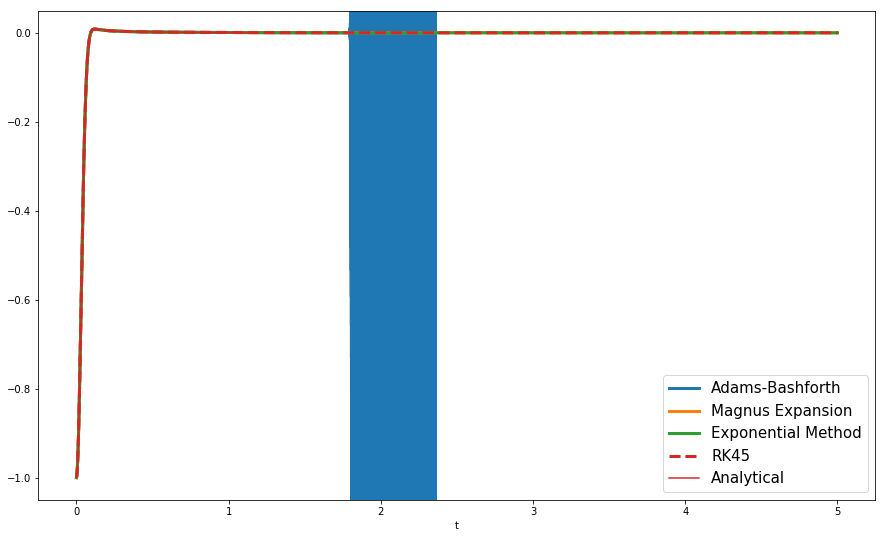

In [81]:
yi = 0
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.real(phiAdams[:,yi]), lw = 3, label = 'Adams-Bashforth')
ax.plot(t, np.real(phi[:,yi]), lw = 3, label = 'Magnus Expansion')
ax.plot(t, np.real(phiExp[:,yi]), lw = 3, label = 'Exponential Method')
ax.plot(sol.t, sol.y[yi], 'C3--', lw = 3, label = 'RK45')
ax.plot(t, solAna(t)[yi], label = 'Analytical')
ax.legend(fontsize = 15)
# ax.set_yscale('log')
ax.set_xlabel('t');
ax.set_ylim(-1.05,0.05)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


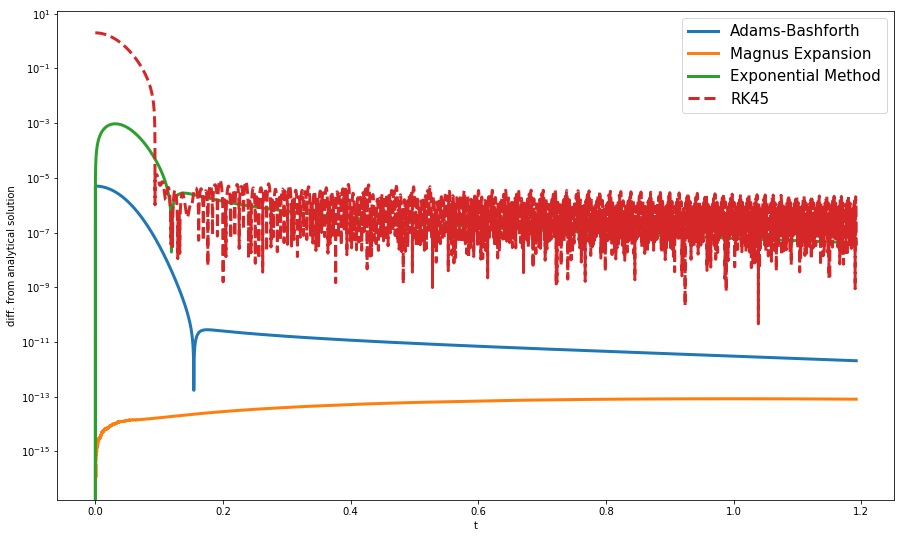

In [82]:
yi = 0
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(solAna(t)[yi]-np.real(phiAdams[:,yi])), lw = 3, label = 'Adams-Bashforth')
ax.plot(t, np.abs(solAna(t)[yi]-np.real(phi[:,yi])), lw = 3, label = 'Magnus Expansion')
ax.plot(t, np.abs(solAna(t)[yi]-np.real(phiExp[:,yi])), lw = 3, label = 'Exponential Method')
ax.plot(sol.t, np.abs(solAna(t)[yi]-np.abs(sol.y[yi])), 'C3--', lw = 3, label = 'RK45')
ax.legend(fontsize = 15)
# ax.set_ylim(1e-17,1e2)
ax.set_yscale('log')
ax.set_ylabel('diff. from analytical solution');
ax.set_xlabel('t');

Apparently the analytical solution used is only valid up unto $t=1.2~\text{s}$, after which the $erfi$ function quickly explodes. Again the Magnus Expansion method gives best fidelity. The Adams-Bashforth method is in 2nd place, but is not stable, hence diverges quickly around $t=2~\text{s}$.

### Testing a Zener-Landau Crossing Example

In [83]:
def Ham(t):
    return np.array([[0, Omega(t)*np.exp(1j*omega*t)],[Omega(t)*np.exp(-1j*omega*t), omega0(t)]])/(1j)

In [84]:
def differentialEquation(t, c):
    c1 = (Omega(t)*np.exp(1j*omega*t)*c[1])/1j
    c2 = (Omega(t)*np.exp(-1j*omega*t)*c[0]+omega0(t)*c[1])/1j
    return [c1, c2]

In [172]:
beta = 5
omega = 1
Omega = lambda t: 1
Delta = lambda t: beta*t
omega0 = lambda t: omega-Delta(t)

dt = 1e-4
t = np.arange(-30,30,dt)
phi = propagateMagnus4thHamFun(Ham, t, np.array([1,0]), dt)

In [173]:
def propagateExp(Hamiltonians, phi0, dt):
    phi = np.zeros([len(Hamiltonians), len(phi0)], dtype = complex)
    phi[0] = phi0
    
    for idH, H in enumerate(Hamiltonians[:-1]):
        phi[idH+1] = expm(H*dt)@phi[idH]
    return phi

In [194]:
Hamiltonians = [None]*t.size
for idt, ti in enumerate(t):
    Hamiltonians[idt] = Ham(ti)
Hamiltonians = np.array(Hamiltonians)

In [193]:
phiExp = propagateExp(Hamiltonians, np.array([1,0]), dt)

list

In [195]:
phiAdamsBashforth = propagateAdamsBashforth(Hamiltonians*1j, np.array([1,0]), dt)

In [176]:
sol = solve_ivp(differentialEquation, [t.min(), t.max()], [1+0j,0+0j], t_eval=t)

In [178]:
from mpmath import hermite as eval_hermite
from mpmath import hyp1f1
from tqdm import tqdm

def analyticalSolution(t):
    sq5 = np.sqrt(5)
    a = sq5*eval_hermite(-1-1j/5,np.sqrt(5)*(-15-15j))
    b = hyp1f1(1j/10,0.5,0.5*5j*t**2)
    c = (75+75j)*eval_hermite(-1j/5,sq5*(0.5+0.5j)*t)
    d = hyp1f1(1+1j/10,3/2,2250j)
    e = sq5*eval_hermite(-1-1j/5,sq5*(-15-15j))
    f = hyp1f1(1j/10,0.5,2250j)
    g = (75+75j)*eval_hermite(-1j/5,(-15-15j)*sq5)
    h = hyp1f1(1+1j/10,3/2,2250j)
    x = (a*b-c*d)/(e*f-g*h)
    
    return x

nSlice = 250
ana = np.empty(len(t)//nSlice, dtype = complex)
for idt, ti in enumerate(t[::nSlice]):
    ana[idt] = complex(analyticalSolution(ti))

In [179]:
Pfull = np.abs(ana)**2

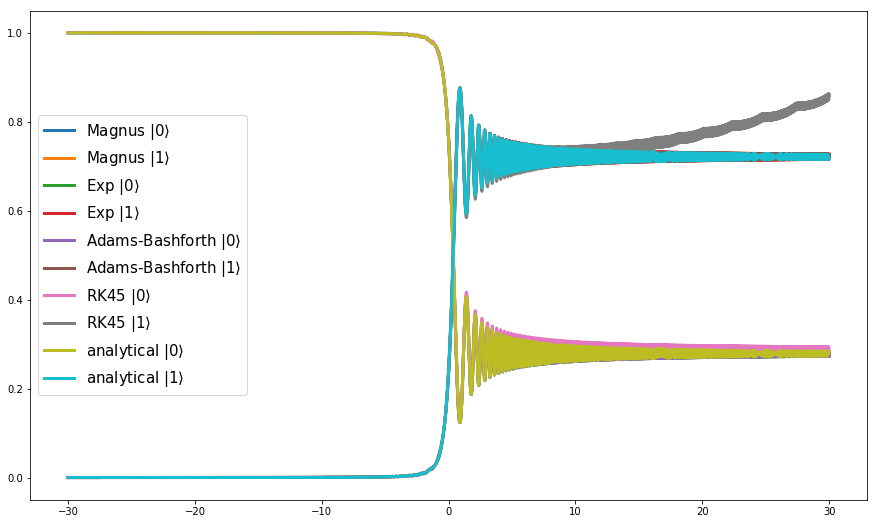

In [196]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, np.abs(phi[:,0])**2, label = r'Magnus $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phi[:,1])**2, label = r'Magnus $\left|1\right\rangle$', lw = 3)
ax.plot(t, np.abs(phiExp[:,0])**2, label = r'Exp $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phiExp[:,1])**2, label = r'Exp $\left|1\right\rangle$', lw = 3)
ax.plot(t, np.abs(phiAdamsBashforth[:,0])**2, label = r'Adams-Bashforth $\left|0\right\rangle$', lw = 3)
ax.plot(t, np.abs(phiAdamsBashforth[:,1])**2, label = r'Adams-Bashforth $\left|1\right\rangle$', lw = 3)
ax.plot(sol.t, np.abs(sol.y[0])**2, label = r'RK45 $\left|0\right\rangle$', lw = 3)
ax.plot(sol.t, np.abs(sol.y[1])**2, label = r'RK45 $\left|1\right\rangle$', lw = 3)
ax.plot(t[::nSlice], Pfull, '-', label = r'analytical $\left|0\right\rangle$', lw = 3)
ax.plot(t[::nSlice], 1-Pfull, '-', label = r'analytical $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)

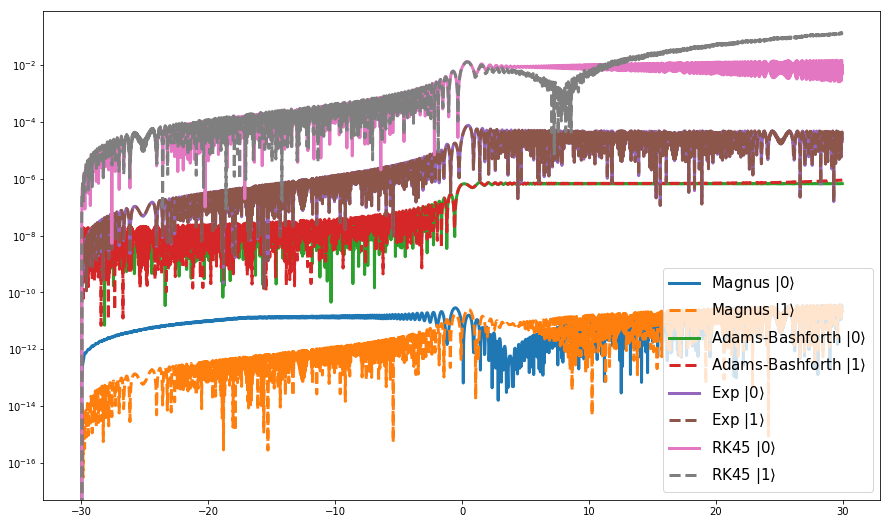

In [204]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t[::nSlice], np.abs((Pfull)-np.abs(phi[:,0][::nSlice])**2), label = r'Magnus $\left|0\right\rangle$', lw = 3)
ax.plot(t[::nSlice], np.abs((1-Pfull)-np.abs(phi[:,1][::nSlice])**2), '--', label = r'Magnus $\left|1\right\rangle$', lw = 3)
ax.plot(t[::nSlice], np.abs((Pfull)-np.abs(phiAdamsBashforth[:,0][::nSlice])**2), label = r'Adams-Bashforth $\left|0\right\rangle$', lw = 3)
ax.plot(t[::nSlice], np.abs((1-Pfull)-np.abs(phiAdamsBashforth[:,1][::nSlice])**2), '--', label = r'Adams-Bashforth $\left|1\right\rangle$', lw = 3)
ax.plot(t[::nSlice], np.abs((Pfull)-np.abs(phiExp[:,0][::nSlice])**2), label = r'Exp $\left|0\right\rangle$', lw = 3)
ax.plot(t[::nSlice], np.abs((1-Pfull)-np.abs(phiExp[:,1][::nSlice])**2), '--', label = r'Exp $\left|1\right\rangle$', lw = 3)
ax.plot(sol.t[::nSlice], np.abs((Pfull)-np.abs(sol.y[0][::nSlice])**2), label = r'RK45 $\left|0\right\rangle$', lw = 3)
ax.plot(sol.t[::nSlice], np.abs((1-Pfull)-np.abs(sol.y[1][::nSlice])**2), '--', label = r'RK45 $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)
ax.set_yscale('log');

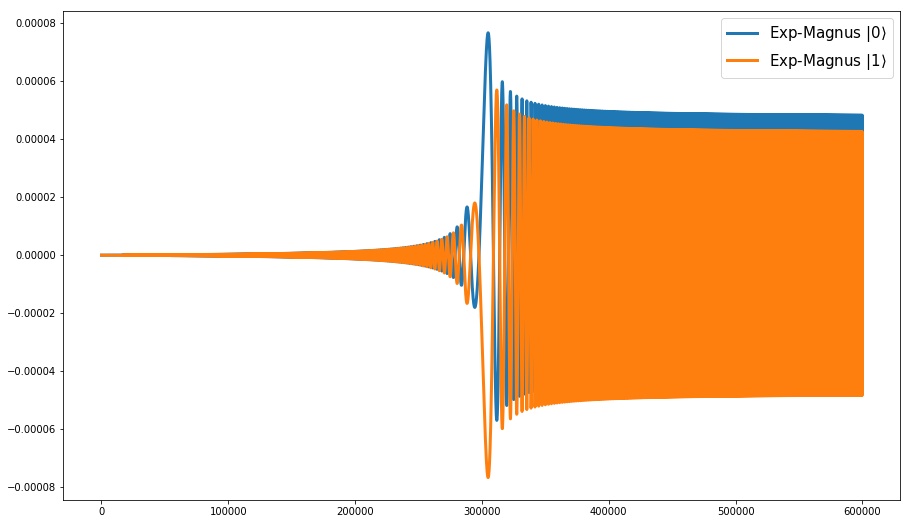

In [198]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot((np.abs(phiExp)**2-np.abs(phi)**2)[:,0], lw = 3, label = r'Exp-Magnus $\left|0\right\rangle$')
ax.plot((np.abs(phiExp)**2-np.abs(phi)**2)[:,1], lw = 3, label = r'Exp-Magnus $\left|1\right\rangle$')
ax.legend(fontsize = 15)

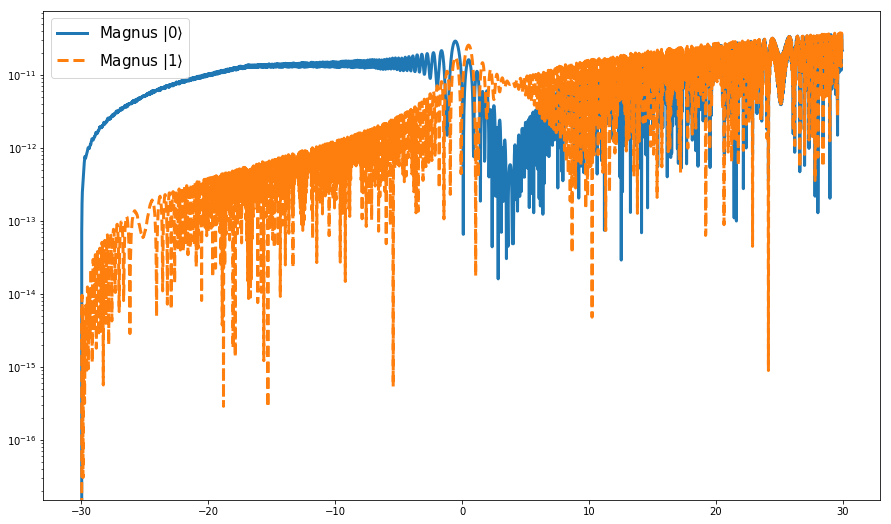

In [199]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t[::nSlice], np.abs((Pfull)-np.abs(phi[:,0][::nSlice])**2), label = r'Magnus $\left|0\right\rangle$', lw = 3)
ax.plot(t[::nSlice], np.abs((1-Pfull)-np.abs(phi[:,1][::nSlice])**2), '--', label = r'Magnus $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)
ax.set_yscale('log');

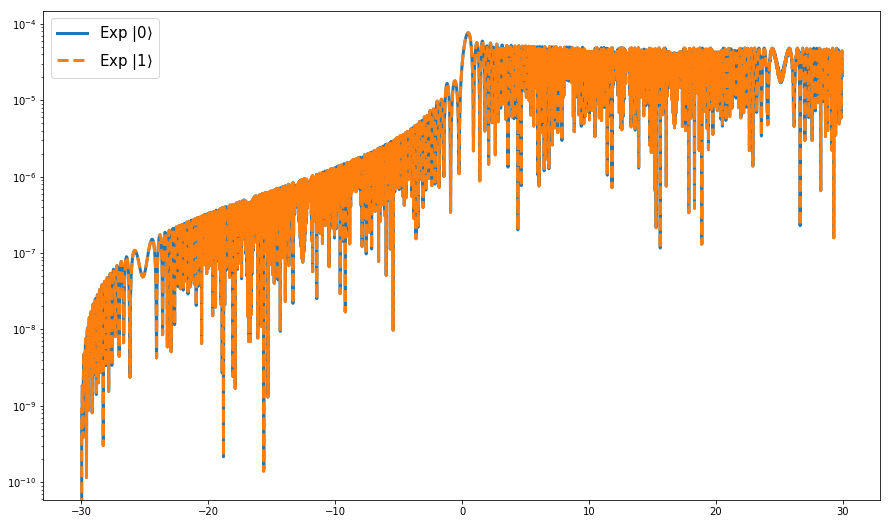

In [200]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t[::nSlice], np.abs((Pfull)-np.abs(phiExp[:,0][::nSlice])**2), label = r'Exp $\left|0\right\rangle$', lw = 3)
ax.plot(t[::nSlice], np.abs((1-Pfull)-np.abs(phiExp[:,1][::nSlice])**2), '--', label = r'Exp $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)
ax.set_yscale('log');

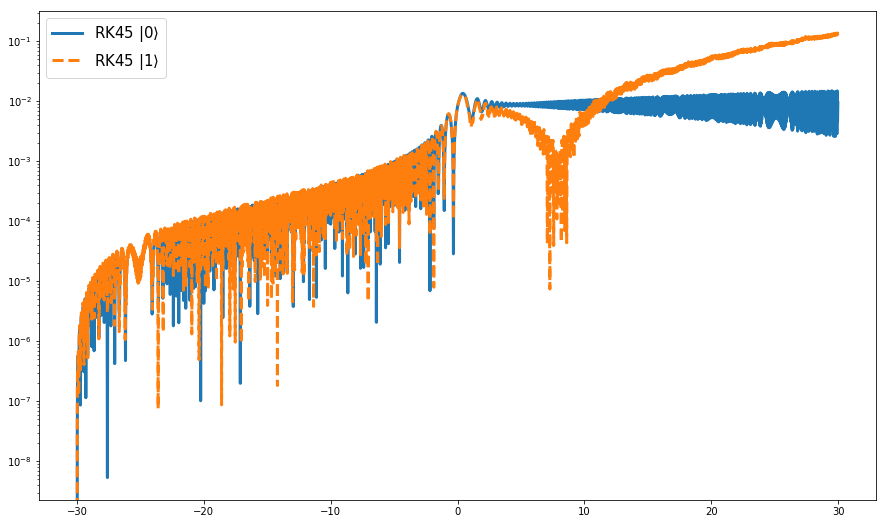

In [201]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(sol.t[::nSlice], np.abs((Pfull)-np.abs(sol.y[0][::nSlice])**2), label = r'RK45 $\left|0\right\rangle$', lw = 3)
ax.plot(sol.t[::nSlice], np.abs((1-Pfull)-np.abs(sol.y[1][::nSlice])**2), '--', label = r'RK45 $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)
ax.set_yscale('log');

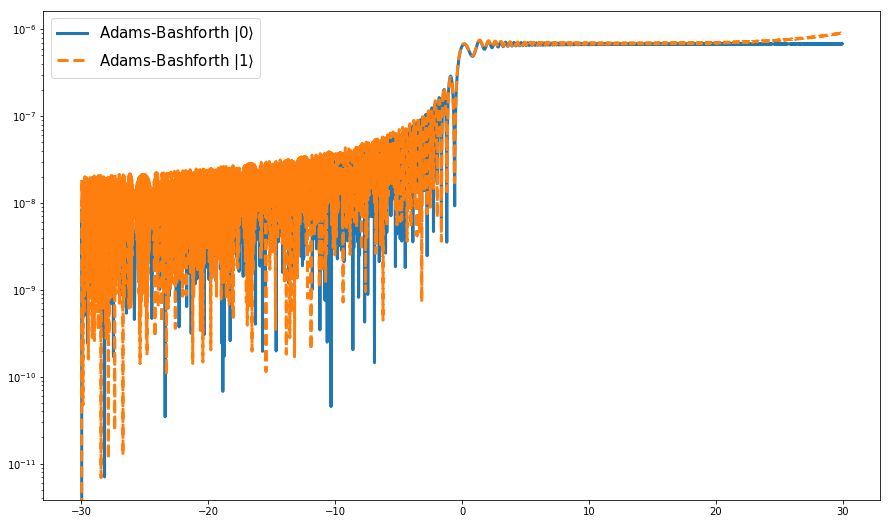

In [202]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t[::nSlice], np.abs((Pfull)-np.abs(phiAdamsBashforth[:,0][::nSlice])**2), label = r'Adams-Bashforth $\left|0\right\rangle$', lw = 3)
ax.plot(t[::nSlice], np.abs((1-Pfull)-np.abs(phiAdamsBashforth[:,1][::nSlice])**2), '--', label = r'Adams-Bashforth $\left|1\right\rangle$', lw = 3)
ax.legend(fontsize = 15)
ax.set_yscale('log');

In [187]:
Hamiltonians = [Ham(ti)*1j for ti in t]

In [188]:
energies = np.empty([len(Hamiltonians),2])
for idH, H in enumerate(Hamiltonians):
    energies[idH] = np.linalg.eigh(H)[0]

Text(0,0.5,'energy')

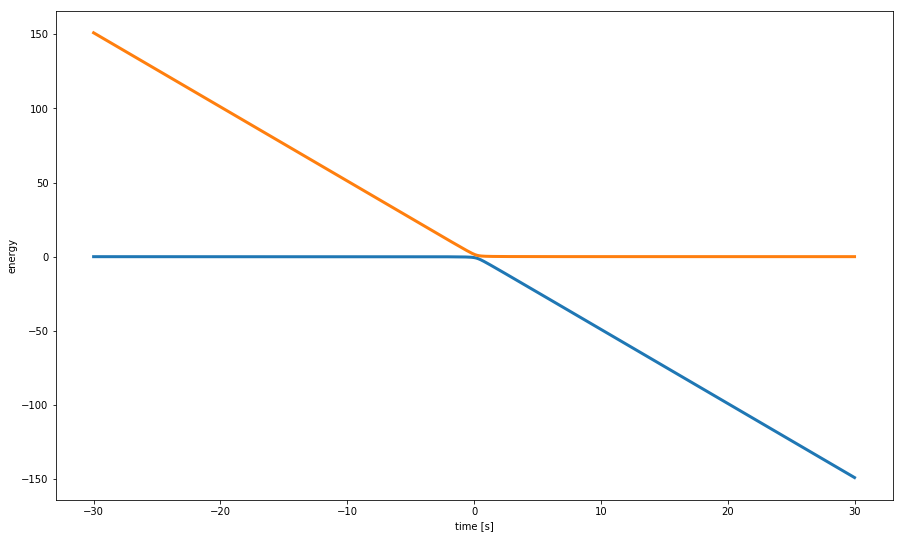

In [189]:
fig, ax = plt.subplots(figsize = (15,9))
ax.plot(t, energies[:,0], lw = 3)
ax.plot(t, energies[:,1], lw = 3)
ax.set_xlabel('time [s]')
ax.set_ylabel('energy')